### Modules

In [37]:
import pandas as pd
import logging
from youtube_search import YoutubeSearch
from pytubefix import YouTube
from pydub import AudioSegment

import re
import os
import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

os.makedirs('datasets/songs', exist_ok=True)
os.makedirs('datasets/wav_songs', exist_ok=True)

### Variables
```yaml
This module contains the configuration for the youtube search and download
You can change the configuration here

YOUTUBE_BASE_URL: The base url for the youtube search
YOUTUBE_SEARCH_MAX_RESULTS: The maximum number of results to return from the youtube search
YOUTUBE_CLIENT_TYPE: The type of client to use for the youtube search
YOUTUBE_MAX_VIDEO_LENGTH: The maximum length of a video in seconds
YOUTUBE_MIN_VIDEO_LENGTH: The minimum length of a video in seconds

SONG_SIZE_PER_TITLE: size (count) songs per title
SEGMENT_LENGTH: The length of each segment in seconds

LAGU_DAERAH_PATH: The path to the lagu daerah dataset
DOWNLOADED_SONGS_PATH: The path to the downloaded songs
SONGS_WAV_PATH: The path to the songs in wav format
```

In [38]:

YOUTUBE_BASE_URL = 'https://www.youtube.com/watch?v='
YOUTUBE_SEARCH_MAX_RESULTS = 40
YOUTUBE_CLIENT_TYPE='IOS'
YOUTUBE_MAX_VIDEO_LENGTH = 450
YOUTUBE_MIN_VIDEO_LENGTH = 30

SONG_SIZE_PER_TITLE=30
SEGMENT_LENGTH = 30

# LAGU_DAERAH_PATH = 'data/lagu_daerah.csv'
# LAGU_DAERAH_PATH = 'data/lagu_daerah_alternatif.csv'
LAGU_DAERAH_PATH = 'data/lagu_daerah_5.csv'
DOWNLOADED_SONGS_PATH = 'data/downloaded_songs.csv'
SONGS_WAV_PATH = 'data/songs_wav.csv'

### Load Scrapping Result

In [39]:
data = pd.read_csv(LAGU_DAERAH_PATH, sep=',')
data.head()

,nama_lagu,asal
0,Kicir-kicir,Jakarta
1,Ampar-ampar Pisang,Kalimantan Selatan
2,Yamko Rambe Yamko,Papua
3,Apuse,Papua Barat
4,Bengawan Solo,Jawa Tengah


### Search and Download Music Function

In [40]:
def search_yt(query, max_results=YOUTUBE_SEARCH_MAX_RESULTS):
    try:
        results = YoutubeSearch(query, max_results).to_dict()
        for result in results:
            result['url'] = YOUTUBE_BASE_URL + result['id']
        return results
    except Exception as e:
        logging.error(f"Error searching YouTube for query '{query}': {e}")
        return []

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def dl_video(url):
    try:
        yt = YouTube(url, client=YOUTUBE_CLIENT_TYPE)
        logging.info(f'Downloading {yt.title}...')
        
        normalized_title = normalized_yt_title(yt.title)
        
        # check if video already downloaded
        filepath= f'datasets/songs/{normalized_title}.mp3'
        if os.path.exists(filepath):
            logging.info(f'File already exists: {filepath}')
            return filepath
        
        audio_stream = yt.streams.get_audio_only()
        
        audio_stream.download(output_path='datasets/songs', filename=normalized_title, mp3=True)
        
        return f'datasets/songs/{normalized_title}.mp3'
    except Exception as e:
        logging.error(f"Error downloading video from URL '{url}': {e}")
        return None
    
def parse_duration(duration_str):
    duration_str = duration_str.replace('.', ':')
    if duration_str.count(':') == 2:
        duration = datetime.datetime.strptime(duration_str, '%H:%M:%S')
    else:
        duration = datetime.datetime.strptime(duration_str, '%M:%S')
        
    return duration.hour * 3600 + duration.minute * 60 + duration.second

In [41]:
dl_results = []

for index, row in data[:15].iterrows():
    # Construct the search keyword
    keyword = f"Lagu Daerah {row['nama_lagu']} asal {row['asal']}"
    searched_songs = search_yt(keyword)
    
    downloaded_count = 0
    for song in searched_songs:
        if downloaded_count >= SONG_SIZE_PER_TITLE:
            logging.info(f"Downloaded {downloaded_count} songs for '{keyword}'")
            break
        
        try:
            duration = parse_duration(song['duration'])
            if duration < YOUTUBE_MAX_VIDEO_LENGTH and duration > YOUTUBE_MIN_VIDEO_LENGTH:
                path = dl_video(song['url'])
                
                # Append the result to downloaded_results list
                dl_results.append({
                    'title': song['title'],
                    'nama_lagu': row['nama_lagu'],
                    'region': row['asal'],
                    'keyword': keyword,
                    'duration': duration,
                    'url': song['url'],
                    'path': path
                })
                logging.info(f"Downloaded: {song['title']} from {song['url']}")
                
                downloaded_count += 1
            else:
                logging.warning(f"Duration of {song['title']} is too long: {duration} seconds")
        except Exception as e:
            logging.error(f"Error processing song {song['title']}: {e}")

2025-01-05 08:49:00,373 - INFO - Downloading KICIR KICIR | Lagu Daerah Jakarta (Betawi) | Diva bernyanyi | Diva The Series Official...
2025-01-05 08:49:00,376 - INFO - File already exists: datasets/songs/kicir_kicir_lagu_daerah_jakarta_betawi_diva_bernyanyi_diva_the_series_official.mp3
2025-01-05 08:49:00,378 - INFO - Downloaded: KICIR KICIR | Lagu Daerah Jakarta (Betawi) | Diva bernyanyi | Diva The Series Official from https://www.youtube.com/watch?v=LU3YHPgRxQo
2025-01-05 08:49:00,711 - INFO - Downloading Tari Daerah ~ Kicir-kicir DKI Jakarta |Rumah Belajar Mawinsya...
2025-01-05 08:49:00,712 - INFO - File already exists: datasets/songs/tari_daerah_kicirkicir_dki_jakarta_rumah_belajar_mawinsya.mp3
2025-01-05 08:49:00,712 - INFO - Downloaded: Tari Daerah ~ Kicir-kicir DKI Jakarta |Rumah Belajar Mawinsya from https://www.youtube.com/watch?v=0EJP74A3Ws4
2025-01-05 08:49:00,951 - INFO - Downloading Kicir Kicir (Lagu Daerah Betawi)...
2025-01-05 08:49:00,952 - INFO - File already exists: 

### Save list of songs to csv

In [49]:
df = pd.DataFrame(dl_results)

df.to_csv('data/downloaded_songs.csv', index=False)

### Convert to wav format

In [50]:
def convert_to_wav(path):
    if path is None:
        logging.error('File path is None')
        return None
    
    try:
        wav_path = path.replace('songs', 'wav_songs').replace('.mp3', '.wav')
        
        if os.path.exists(wav_path):
            logging.info(f'File already exists: {wav_path}')
            return wav_path
        
        logging.info(f'Converting {path} to {wav_path}')
        
        audio = AudioSegment.from_file(path)
        audio.export(wav_path, format='wav')
        
        return wav_path
    except Exception as e:
        logging.error(f'Exception occurred: {e}')
        return None

In [51]:
df['wav_path'] = df['path'].apply(convert_to_wav)

2025-01-05 09:13:11,513 - INFO - File already exists: datasets/wav_songs/kicir_kicir_lagu_daerah_jakarta_betawi_diva_bernyanyi_diva_the_series_official.wav
2025-01-05 09:13:11,515 - INFO - File already exists: datasets/wav_songs/tari_daerah_kicirkicir_dki_jakarta_rumah_belajar_mawinsya.wav
2025-01-05 09:13:11,516 - INFO - File already exists: datasets/wav_songs/kicir_kicir_lagu_daerah_betawi.wav
2025-01-05 09:13:11,516 - INFO - File already exists: datasets/wav_songs/kicir_kicir_lagu_dan_tari_nusantara_lagu_anak.wav
2025-01-05 09:13:11,517 - INFO - File already exists: datasets/wav_songs/kicir_kicir_jakarta.wav
2025-01-05 09:13:11,517 - INFO - File already exists: datasets/wav_songs/kicirkicir_ifan_suady_x_putri_reski_lagu_daerah_jakarta.wav
2025-01-05 09:13:11,518 - INFO - File already exists: datasets/wav_songs/kicir_kicir_lagu_daerah_dki_jakarta_betawi_budaya_indonesia_dongeng_kita.wav
2025-01-05 09:13:11,518 - INFO - File already exists: datasets/wav_songs/kicirkicir_lagu_daerah_ja

In [52]:
df = df[df['wav_path'].notnull()]

In [46]:
df

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,KICIR KICIR | Lagu Daerah Jakarta (Betawi) | D...,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,280,https://www.youtube.com/watch?v=LU3YHPgRxQo,datasets/songs/kicir_kicir_lagu_daerah_jakarta...,datasets/wav_songs/kicir_kicir_lagu_daerah_jak...
1,Tari Daerah ~ Kicir-kicir DKI Jakarta |Rumah B...,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,237,https://www.youtube.com/watch?v=0EJP74A3Ws4,datasets/songs/tari_daerah_kicirkicir_dki_jaka...,datasets/wav_songs/tari_daerah_kicirkicir_dki_...
2,Kicir Kicir (Lagu Daerah Betawi),Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,237,https://www.youtube.com/watch?v=CcFbCjM2jsM,datasets/songs/kicir_kicir_lagu_daerah_betawi.mp3,datasets/wav_songs/kicir_kicir_lagu_daerah_bet...
3,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,234,https://www.youtube.com/watch?v=0wTJULU2REc,datasets/songs/kicir_kicir_lagu_dan_tari_nusan...,datasets/wav_songs/kicir_kicir_lagu_dan_tari_n...
4,Kicir Kicir Jakarta,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,232,https://www.youtube.com/watch?v=jMynoFKskhc,datasets/songs/kicir_kicir_jakarta.mp3,datasets/wav_songs/kicir_kicir_jakarta.wav
...,...,...,...,...,...,...,...,...
85,Bengawan Solo,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo asal Jawa Tengah,274,https://www.youtube.com/watch?v=RokdibqBiqs,datasets/songs/bengawan_solo.mp3,datasets/wav_songs/bengawan_solo.wav
86,Lagu BENGAWAN SOLO dalam Irama Dansa cover UST...,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo asal Jawa Tengah,209,https://www.youtube.com/watch?v=Upu2tU11TB4,datasets/songs/lagu_bengawan_solo_dalam_irama_...,datasets/wav_songs/lagu_bengawan_solo_dalam_ir...
87,BENGAWAN SOLO - NIKEN SALINDRY - KERONCONG,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo asal Jawa Tengah,277,https://www.youtube.com/watch?v=HZAW3FdA3kc,datasets/songs/bengawan_solo_niken_salindry_ke...,datasets/wav_songs/bengawan_solo_niken_salindr...
88,Lagu Bengawan Solo dinyanyikan di konser besar...,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo asal Jawa Tengah,269,https://www.youtube.com/watch?v=9-5f0IpG19E,datasets/songs/lagu_bengawan_solo_dinyanyikan_...,datasets/wav_songs/lagu_bengawan_solo_dinyanyi...


In [53]:
df.to_csv('data/songs_wav.csv', index=False)

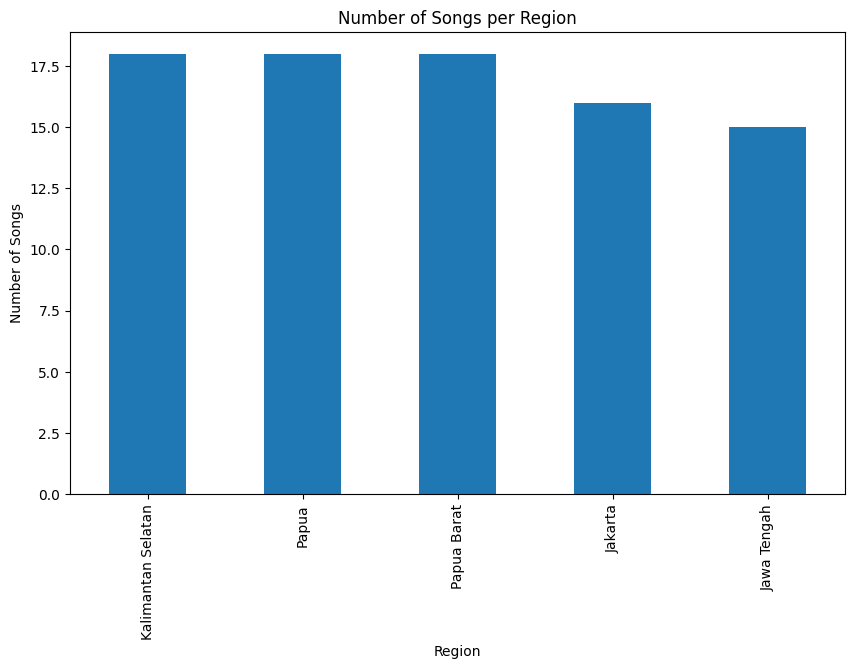

In [54]:
import matplotlib.pyplot as plt

# Count the number of songs per region
region_counts = df['region'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
region_counts.plot(kind='bar')
plt.title('Number of Songs per Region')
plt.xlabel('Region')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.show()